In [ ]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.feature import LAND, BORDERS
import networkx as nx
import pandas as pd 
from pyproj import Transformer
import numpy as np
import torch
import xarray as xr
from tqdm import tqdm
import include as base
import matplotlib.pyplot as plt

from matplotlib import rcParams
from cycler import cycler
colors = {
    
    'c_darkblue': '#2F7194',
    'c_red': '#ec7070',
    'c_darkgreen': '#48675A',
    'c_lightblue': '#97c3d0',
    'c_lightgreen': '#AFD8BC',
    'c_lightbrown': '#C6BFA2',
    'c_orange': '#EC9F7E',
    'c_yellow': '#F5DDA9',
    'c_darkgrey': '#3D4244',
    'c_pink': '#F8A6A6',
    'c_purple': '#A07CB0',
    'c_lightgrey': '#AFC1B9',
}
rcParams['axes.prop_cycle'] = cycler(color=list(colors.values()))
fs=9
rcParams.update(**{
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amssymb} \usepackage{amsmath}",
    "font.size": fs, 
    "axes.titlesize": fs,
    "axes.labelsize": fs,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "grid.linewidth": 0.5,
    "savefig.bbox": "tight",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})

In [ ]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

In [ ]:
def plot_map(data: xr.DataArray, country_coords: pd.DataFrame, *, special_countries: list = None, extent: list = None, 
             width_factor: float = 1.0, size_factor: float = 1.0, arrow_dict: dict = {}):
    
    """ Plots a world map"""
    
    # Create an empty nx.network
    nw = nx.DiGraph()
    
    special_countries = [] if special_countries is None else special_countries
    
    export_nodes = data.sum("Country B", skipna=True)
    for country in export_nodes.coords['Country A'].data:
        if country == 'Other':
            continue
        nw.add_node(country, pos=(country_coords.loc[country]['latitude'],country_coords.loc[country]['longitude']), type='Exporter', 
                    export_value=2e-3*export_nodes.sel({"Country A": country}).data.item(), import_value=0)
    
    # Add the importers
    import_nodes = data.sum("Country A", skipna=True)
    for country in import_nodes.coords['Country B'].data:
        if country == 'Other':
            continue
        if country in nw.nodes():
            export_value = nw.nodes[country]["export_value"]
        else:
            export_value = 0
        nw.add_node(country, pos=(country_coords.loc[country]['latitude'],country_coords.loc[country]['longitude']), type='Importer', 
                    import_value=2e-3*import_nodes.sel({"Country B": country}).data.item(), export_value = export_value)
    
    # Add edges
    for country_A in data.coords["Country A"].data:
        if country_A == "Other":
            continue
        for country_B in data.coords["Country B"].data:
            if country_B == "Other":
                continue
            
            # Skip special edges
            skip = False
            for special_country_pair in special_countries:
                if country_A == special_country_pair[0] and country_B == special_country_pair[1]:
                    skip = True
                    break
            if skip:
                continue
                
            T = data.sel({"Country A": country_A, "Country B": country_B})
            if T> 0:
                nw.add_edge(country_A, country_B, weight=5e-5*T.data.item())
    
    fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(projection=ccrs.Mercator()))
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', facecolor=colors['c_lightbrown'])
    sea = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m', facecolor=colors['c_lightblue'], alpha=0.2)
    ax.axis('off')
    ax.add_feature(land, zorder=-2)
    ax.add_feature(sea, zorder=-3)
    ax.add_feature(BORDERS, lw=0.2, zorder=-1)
    
    # Plot the exporters
    pos = dict((k, transformer.transform(*v)) for k, v in nx.get_node_attributes(nw, 'pos').items())
    size = nx.get_node_attributes(nw, 'export_value')
    nx.draw_networkx_nodes(nw, pos, node_size=size_factor * np.array(list(size.values())), ax=ax, node_color=colors["c_darkblue"], alpha=0.5)
    
    size = nx.get_node_attributes(nw, 'import_value')
    nx.draw_networkx_nodes(nw, pos, node_size=size_factor * np.array(list(size.values())), ax=ax, node_color=colors["c_red"], alpha=0.5)
    
    # Add edges for special countries
    arrow_kwargs = dict(alpha=0.7, connectionstyle='arc3, rad=0.2', arrowsize=10)
    arrow_kwargs.update(**arrow_dict)
    
    for special_country_pair in special_countries:
        country_1, country_2 = special_country_pair
        nx.draw_networkx_edges(nw, {country_1: pos[country_1], country_2: pos[country_2]}, [special_country_pair], connectionstyle='arc3, rad=0.2', arrowstyle='-',
                           width=5e-5*data.sel({"Country A": country_1, "Country B": country_2}).data.item(), alpha=0.5)
    _ = nx.draw_networkx_edges(nw, pos, ax=ax, width=width_factor * np.maximum(0.2, np.array(list(nx.get_edge_attributes(nw, 'weight').values()))), **arrow_kwargs)
    
    
    # World
    extent = [-180, 180, -70, 60] if extent is None else extent
    ax.set_extent(extent)
    
    return plt

In [162]:
# Read the country coordinates
country_coords = pd.read_csv("/Users/thomasgaskin/FAOSTAT_data/Country_coords.csv", index_col=0)
for pair in [("Czech Republic", "Czechia"), ("Macedonia [FYROM]", "North Macedonia"), ("Swaziland", "Eswatini"),
             ("Brunei", "Brunei Darussalam"), ("Congo [DRC]", "DR Congo"), ("Montenegro", "Serbia and Montenegro"),
             ("Palestinian Territories", "Palestine"), ("Moldova", "Republic of Moldova"), ("Sudan", "Sudan (former)"), ("Congo [Republic]", "Congo"),
             ("Cape Verde", "Cabo Verde"), ("Sudan", "South Sudan")]:
    country_coords.loc[pair[1]] = country_coords.loc[pair[0]]

In [ ]:
# Commodity
for comm in ['Rice', 'Wheat', 'Bananas', 'Avocados', 'Wine', 'Vegetables', 'Chocolate', 'Cocoa Beans']:
    try:
        plot_map(xr.open_dataarray(f"/Users/thomasgaskin/FAOSTAT_data/{comm}/All_Data_{comm}_Quantity_2000-2022_pooled_0.95.nc").sel({"Year": 2022}).mean("Reporter", skipna=True), country_coords, arrow_dict=dict(arrowstyle='-'), extent=[-180, 180, -60, 73], size_factor=0.5, width_factor=0.5).savefig(f"/Users/thomasgaskin/FAOSTAT_data/{comm}/{comm}_map.png", dpi=300)
    except: 
        continue

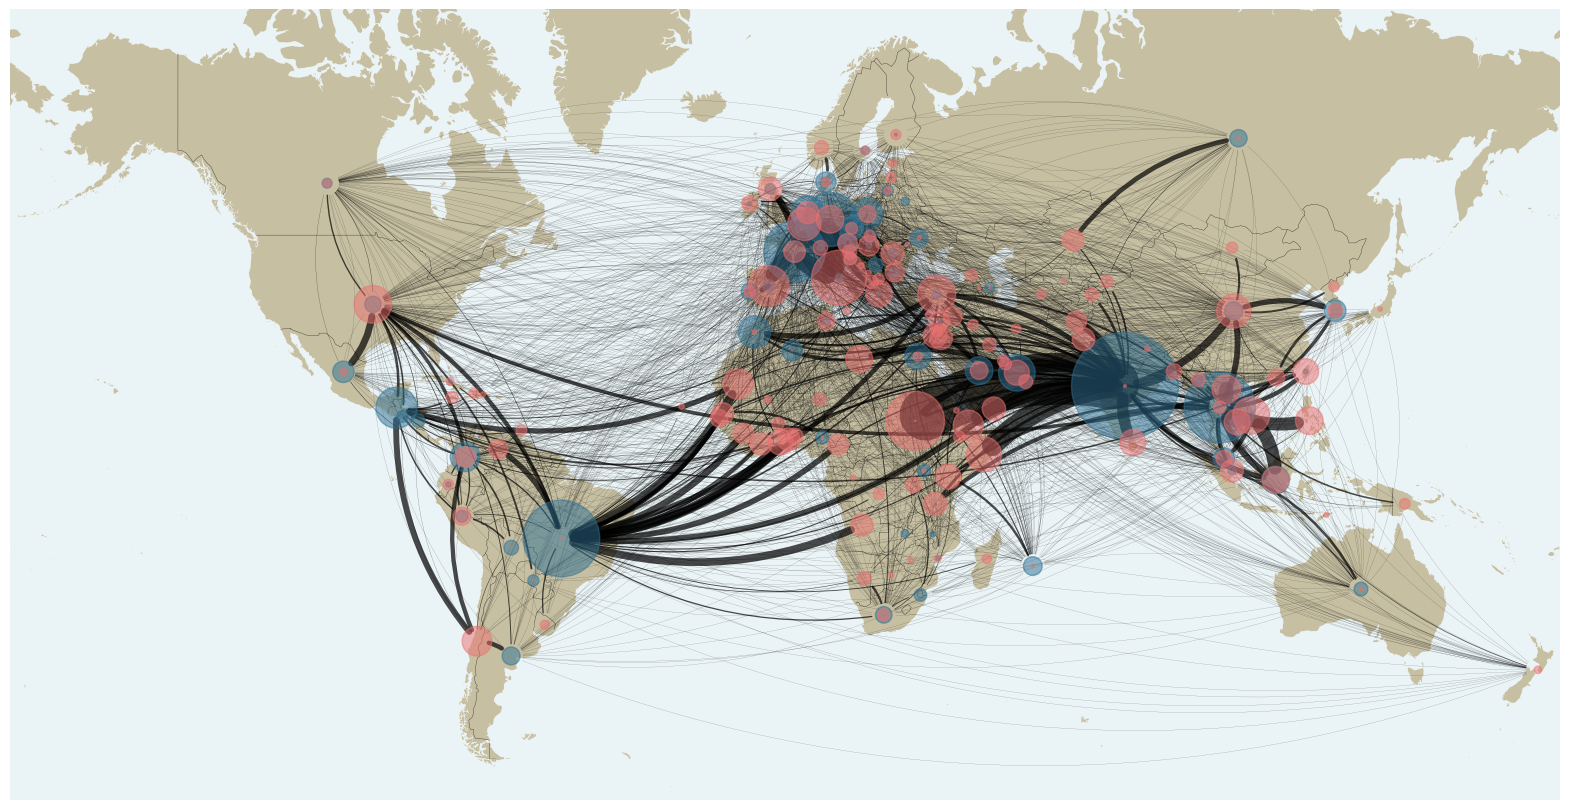

In [165]:
plot_map(xr.open_dataarray(f"/Users/thomasgaskin/FAOSTAT_data/Refined sugar/All_Data_Refined sugar_Quantity_2000-2022_pooled_0.95.nc").sel({"Year": 2022}).mean("Reporter", skipna=True), country_coords, arrow_dict=dict(arrowstyle='-'), extent=[-180, 180, -60, 73], size_factor=0.5, width_factor=0.5).savefig(f"/Users/thomasgaskin/FAOSTAT_data/Refined sugar/Refined sugar_map.png", dpi=300)